<a href="https://colab.research.google.com/github/saurav528/saurav528/blob/main/GrowthStageAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee

ee.Authenticate()

ee.Initialize(project='agrofram')

In [ ]:
# Step 2: Define Region of Interest (ROI) and Load Sentinel-2 Imagery
# Replace with your coordinates
xmin, ymin, xmax, ymax = [75.75, 30.85, 76.05, 31.05]  # Define your bounding box coordinates
roi = ee.Geometry.Rectangle([xmin, ymin, xmax, ymax])

# Load Sentinel-2 imagery
sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(roi) \
    .filterDate('2018-01-01', '2024-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Filter clouds

# Add NDVI to each image in the collection
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

sentinel2 = sentinel2.map(add_ndvi)

# Step 3: Create a Time Series of NDVI Values
def extract_ndvi_time_series(collection, roi):
    def extract_values(image):
        date = image.date().format('YYYY-MM-dd')
        mean_ndvi = image.select('NDVI').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=30,
            maxPixels=1e8
        ).get('NDVI')
        return ee.Feature(None, {'date': date, 'NDVI': mean_ndvi})

    return collection.map(extract_values)

# Extract NDVI time series for the ROI
ndvi_time_series = extract_ndvi_time_series(sentinel2, roi)

# Convert the time series into a pandas dataframe for further processing
import pandas as pd
ndvi_list = ndvi_time_series.getInfo()
ndvi_df = pd.DataFrame([f['properties'] for f in ndvi_list['features']])
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df.set_index('date', inplace=True)

# Show the first few rows of the NDVI time series
print(ndvi_df.head())


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


                NDVI
date                
2018-01-08  0.317086
2018-01-08  0.444874
2018-01-13  0.293260
2018-01-13  0.426013
2018-01-15  0.402651


In [ ]:
ndvi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1162 entries, 2018-01-08 to 2024-12-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NDVI    1162 non-null   float64
dtypes: float64(1)
memory usage: 18.2 KB


In [ ]:
import pandas as pd
import numpy as np

# Function to compute NDVI and add it to the image
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')  # NDVI = (NIR - Red) / (NIR + Red)
    return image.addBands(ndvi)  # Add NDVI as a new band

# Apply the function to add NDVI to the image
sentinel2 = sentinel2.map(add_ndvi)  # Apply to the entire collection

# Function to extract NDVI time series
def extract_ndvi_time_series(collection, roi):
    def extract_values(image):
        date = image.date().format('YYYY-MM-dd')
        mean_ndvi = image.select('NDVI').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=30,
            maxPixels=1e8
        ).get('NDVI')
        return ee.Feature(None, {'date': date, 'NDVI': mean_ndvi})

    return collection.map(extract_values)

# Extract NDVI time series for the ROI (replace 'sentinel2' with your image collection variable)
ndvi_time_series = extract_ndvi_time_series(sentinel2, roi)

# Convert the time series into a pandas dataframe for further processing
ndvi_list = ndvi_time_series.getInfo()
ndvi_df = pd.DataFrame([f['properties'] for f in ndvi_list['features']])
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df.set_index('date', inplace=True)

# Reshape data for LSTM
# Example: using NDVI data as time series input to LSTM
window_size = 10  # Example window size (adjust as needed)

# Function to create dataset for time-series prediction (sliding window approach)
def create_dataset(df, window_size=10):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i + window_size].values)  # Features: past NDVI values
        y.append(df.iloc[i + window_size]['NDVI'])  # Target: next NDVI value
    return np.array(X), np.array(y)

# Create LSTM dataset
X, y = create_dataset(ndvi_df[['NDVI']], window_size)

# Normalize the dataset (you can use MinMaxScaler or StandardScaler from sklearn)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)  # Normalize the X data

# Now, X_scaled and y are ready for LSTM training
print("Shape of input data for LSTM:", X_scaled.shape)
print("Shape of output data for LSTM:", y.shape)

# Example: Display the first few rows of the reshaped dataset
print(pd.DataFrame(X_scaled.reshape(-1, X_scaled.shape[-1]))[:10])


Shape of input data for LSTM: (1152, 10, 1)
Shape of output data for LSTM: (1152,)
          0
0  0.477359
1  0.659332
2  0.443431
3  0.632474
4  0.599206
5  0.648150
6  0.709326
7  0.767622
8  0.707618
9  0.760839


                NDVI
date                
2018-01-08  0.317086
2018-01-08  0.444874
2018-01-13  0.293260
2018-01-13  0.426013
2018-01-15  0.402651


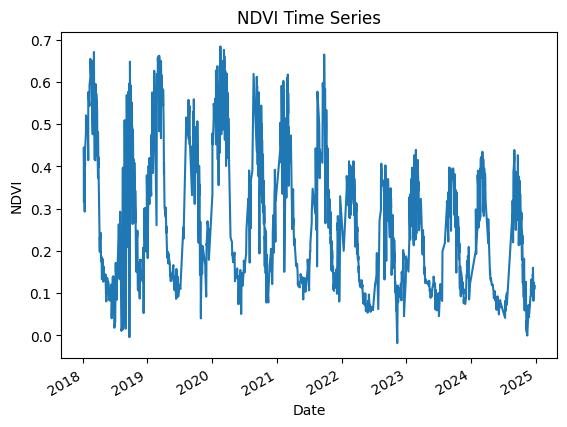

In [ ]:
# Apply NDVI calculation to the image collection
sentinel2 = sentinel2.map(add_ndvi)

# Step 4: Create a Time Series of NDVI Values
# Define a function to extract NDVI time series
def extract_ndvi_time_series(collection, roi):
    def extract_values(image):
        date = image.date().format('YYYY-MM-dd')
        mean_ndvi = image.select('NDVI').reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=roi,
            scale=30,
            maxPixels=1e8
        ).get('NDVI')
        return ee.Feature(None, {'date': date, 'NDVI': mean_ndvi})

    return collection.map(extract_values)

# Extract NDVI time series for the ROI (apply the function to the Sentinel-2 collection)
ndvi_time_series = extract_ndvi_time_series(sentinel2, roi)

# Convert the time series into a pandas dataframe for further processing
import pandas as pd
ndvi_list = ndvi_time_series.getInfo()  # Extract the data to a Python list
ndvi_df = pd.DataFrame([f['properties'] for f in ndvi_list['features']])  # Create DataFrame from the list
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])  # Convert the date column to datetime
ndvi_df.set_index('date', inplace=True)  # Set the date column as the index

# Show the first few rows of the NDVI time series
print(ndvi_df.head())  # Preview the extracted NDVI time series data

# Optionally, plot the NDVI time series using pandas' plot function
import matplotlib.pyplot as plt
ndvi_df['NDVI'].plot(title="NDVI Time Series", ylabel="NDVI", xlabel="Date")
plt.show()


                NDVI
date                
2018-01-08  0.317086
2018-01-08  0.444874
2018-01-13  0.293260
2018-01-13  0.426013
2018-01-15  0.402651


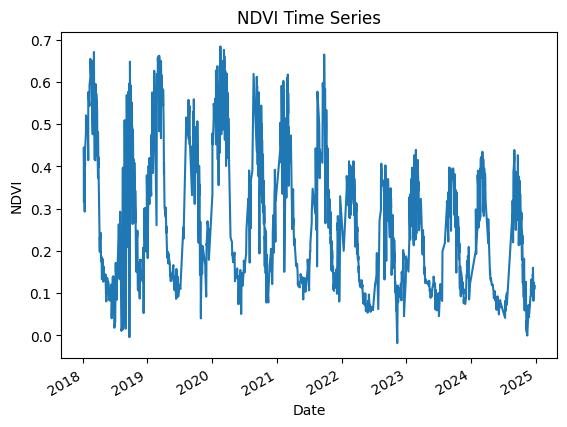

In [ ]:
# Extract NDVI time series
ndvi_time_series = extract_ndvi_time_series(sentinel2, roi)

# Function to convert the extracted Earth Engine data to a Pandas DataFrame
def extract_to_dataframe(ndvi_time_series):
    # Get the data as a list from Earth Engine
    ndvi_list = ndvi_time_series.getInfo()

    # Create a DataFrame from the extracted data
    ndvi_df = pd.DataFrame([f['properties'] for f in ndvi_list['features']])

    # Ensure the 'date' column is converted to datetime
    ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
    ndvi_df.set_index('date', inplace=True)

    return ndvi_df

# Call the function to extract and create DataFrame
ndvi_df = extract_to_dataframe(ndvi_time_series)

# Show the first few rows of the NDVI time series DataFrame
print(ndvi_df.head())

# Optionally, visualize the NDVI time series
import matplotlib.pyplot as plt
ndvi_df['NDVI'].plot(title="NDVI Time Series", ylabel="NDVI", xlabel="Date")
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize NDVI values (LSTMs perform better with normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))
ndvi_scaled = scaler.fit_transform(ndvi_df[['NDVI']])

# Create sequences for LSTM (using previous `n` days to predict the next day)
def create_sequences(data, sequence_length=30):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length])  # next day's NDVI is the target
    return np.array(sequences), np.array(targets)

# Create sequences from the scaled NDVI data
sequence_length = 30  # Using 30 days of data to predict the next day's NDVI
X_lstm, y_lstm = create_sequences(ndvi_scaled)

# Reshape X_lstm to be (samples, timesteps, features)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)  # 1 feature (NDVI)

# Print the shapes of X_lstm and y_lstm to ensure they're correct
print(f"X_lstm shape: {X_lstm.shape}")
print(f"y_lstm shape: {y_lstm.shape}")


X_lstm shape: (1132, 30, 1)
y_lstm shape: (1132, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM model
model = Sequential()

# LSTM layer with 50 units, input_shape (30 timesteps, 1 feature)
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_lstm.shape[1], 1)))

# Output layer to predict NDVI value
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(X_lstm) * 0.8)
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.1394 - val_loss: 0.0149
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0255 - val_loss: 0.0128
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0213 - val_loss: 0.0109
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0180 - val_loss: 0.0080
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0144 - val_loss: 0.0091
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0164 - val_loss: 0.0070
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0145 - val_loss: 0.0078
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0125 - val_loss: 0.0091
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0137 - val_loss: 0.0077
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0135 - val_loss: 0.0103
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0147 - val_loss: 0.0061
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

In [ ]:
print(model.name)  # This will print the model's name


sequential_1


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values to get back the NDVI scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate model performance using Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Mean Squared Error: 0.0028095938969265113


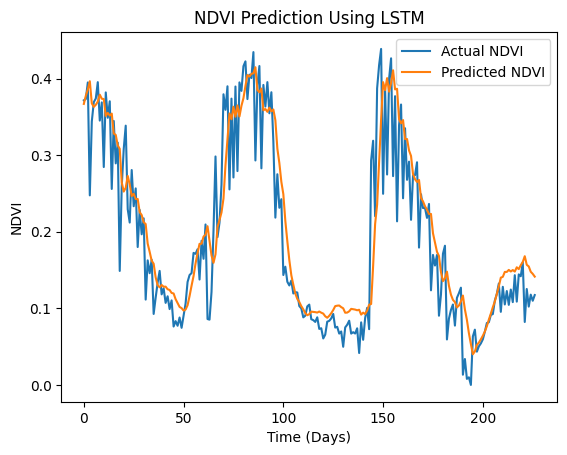

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.plot(y_test_rescaled, label='Actual NDVI')
plt.plot(y_pred_rescaled, label='Predicted NDVI')
plt.legend()
plt.xlabel('Time (Days)')
plt.ylabel('NDVI')
plt.title('NDVI Prediction Using LSTM')
plt.show()


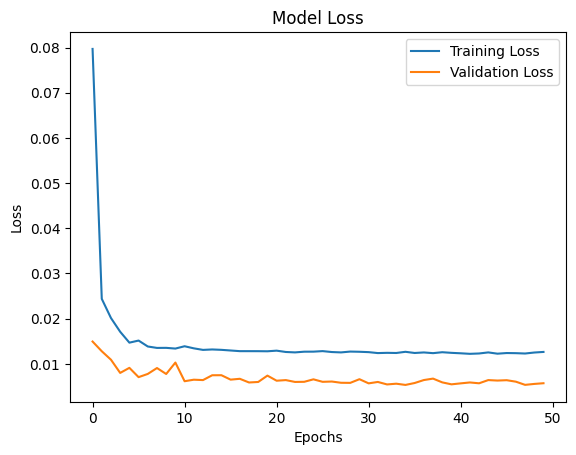

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()
